# To determine what features will best predict cpu/event

we'll calculate averages of cpu/event per CPU and processing type and use that dummy predictor
we'll fit separately fastBmk, bogomips, hs06, whetstone to cpu/event for each processing type adn use that as a predictor

compare all 5.


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict

from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score


### Get datasets

In [2]:
jobs = pd.DataFrame()
input_files=['job_2017-04.csv','job_2017-05.csv']
tmp=[]
for input_file in input_files:
    tmp.append(pd.read_csv(input_file).set_index('pandaid'))
jobs = pd.concat(tmp)

jobs = jobs[jobs['nevents']>20]
jobs = jobs[jobs['inputsize']>1024]

del jobs['cputime']
del jobs['walltime']
del jobs['nevents']
del jobs['cpueff']
del jobs['wallPerEvent']
del jobs['inputsize']

jobs.head()

,hs06,processingtype,cpuPerEvent
pandaid,,,
3352703758,107,recon,4.436667
3354732793,10,evgen,1.100000
3326375042,96,reprocessing,12.623182
3327803396,77,merge,0.358200
3330689156,90,merge,0.337855


In [3]:
input_files=['benchmark_2017-04.csv','benchmark_2017-05.csv']
tmp=[]
for input_file in input_files:
    tmp.append(pd.read_csv(input_file).set_index('pandaid'))
benchmarks = pd.concat(tmp)

print(benchmarks.columns)

del benchmarks['ip']
del benchmarks['site']
del benchmarks['meminfo']

print(benchmarks.columns)

benchmarks.head()

Index(['bogomips', 'ip', 'site', 'mpnum', 'cpuname', 'meminfo', 'fastBmk',
       'whetstone'],
      dtype='object')
Index(['bogomips', 'mpnum', 'cpuname', 'fastBmk', 'whetstone'], dtype='object')


,bogomips,mpnum,cpuname,fastBmk,whetstone
pandaid,,,,,
3322806223,5333.52,1,QEMU Virtual CPU version (cpu64-rhel6),9.223674,3195.99
3322633663,5000.00,1,Intel(R) Xeon(R) CPU E5420 @ 2.50GHz,12.129380,2749.34
3322488785,4988.06,1,Intel(R) Xeon(R) CPU E5-2680 v3 @ 2.50GHz,23.731048,3599.70
3322806277,5333.16,1,Intel(R) Xeon(R) CPU X5650 @ 2.67GHz,12.240734,3426.18
3322875248,5332.58,1,Intel(R) Xeon(R) CPU E5430 @ 2.66GHz,12.349914,2911.33


### join dataframes and filter out bad rows

In [4]:
benchmarks = benchmarks.join(jobs,how='inner')
#benchmarks = benchmarks[benchmarks.cpuPerMB > 0]
#benchmarks = benchmarks[benchmarks.cpuPerEvent > 0]
benchmarks = benchmarks[benchmarks.mpnum == 1]

del benchmarks['mpnum']

benchmarks.head()

,bogomips,cpuname,fastBmk,whetstone,hs06,processingtype,cpuPerEvent
pandaid,,,,,,,
3323737831,5199.28,Intel(R) Xeon(R) CPU E5-2650 v2 @ 2.60GHz,14.863749,3612.79,10,simul,73.644
3323782011,5199.25,Intel(R) Xeon(R) CPU E5-2650 v2 @ 2.60GHz,14.869888,3628.96,10,evgen,154.110
3323782017,4189.98,Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz,18.136020,3306.22,10,evgen,159.280
3323788151,5199.24,Intel(R) Xeon(R) CPU E5-2640 v3 @ 2.60GHz,20.642202,3495.29,10,evgen,167.210
3323820043,4787.82,Intel(R) Xeon(R) CPU E5620 @ 2.40GHz,6.792453,1532.55,13,evgen,426.825


### split over different processing types 

In [5]:
UniqueProcessingTypes = benchmarks.processingtype.unique()
print(UniqueProcessingTypes)
UniqueProcessingTypes=UniqueProcessingTypes.tolist()

UniqueProcessingTypes.remove('overlay')
UniqueProcessingTypes.remove('deriv')

#create a dict for all the dataframes to be filled later
ProcessingType = {elem : pd.DataFrame for elem in UniqueProcessingTypes}

#filling up data frames
for key in ProcessingType.keys():
    ProcessingType[key] = benchmarks[:][benchmarks.processingtype == key]
    

['simul' 'evgen' 'reprocessing' 'merge' 'recon' 'pmerge' 'pile' 'overlay'
 'deriv']


### plot correlations

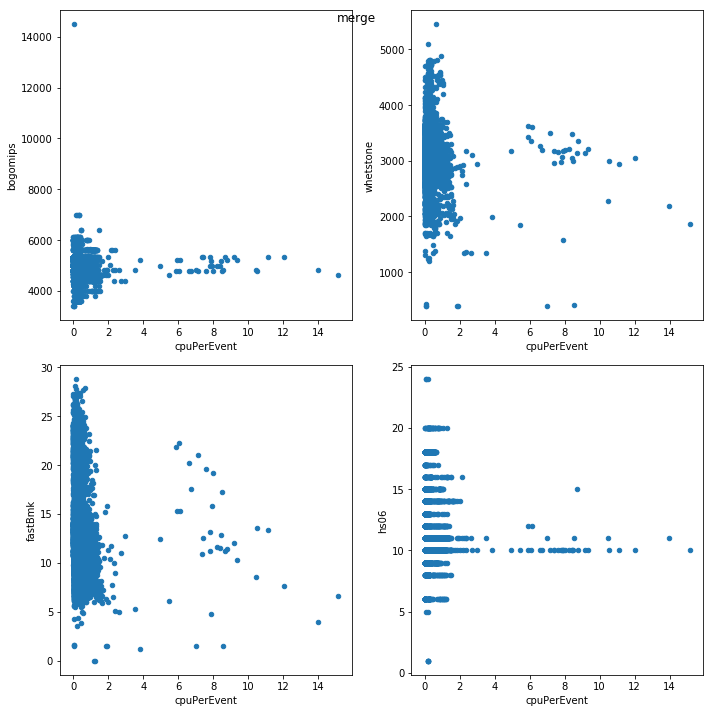

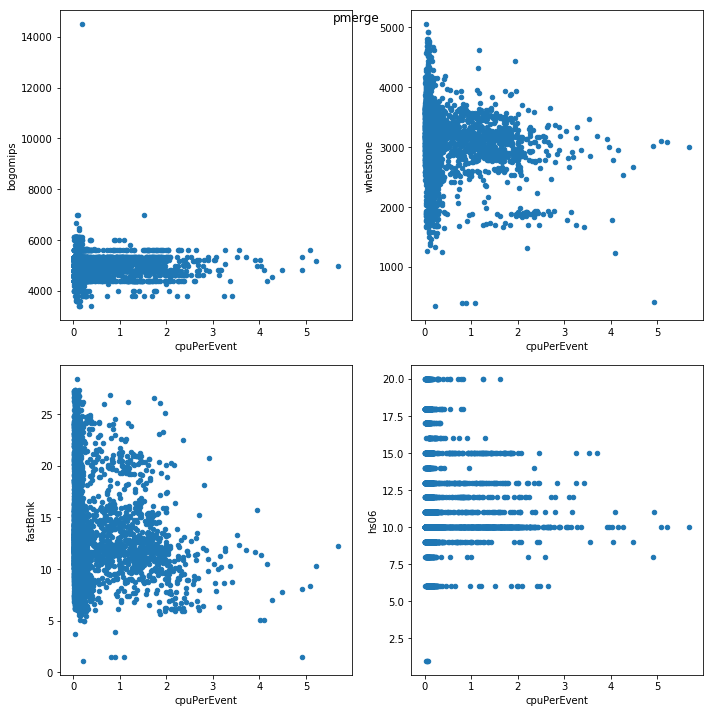

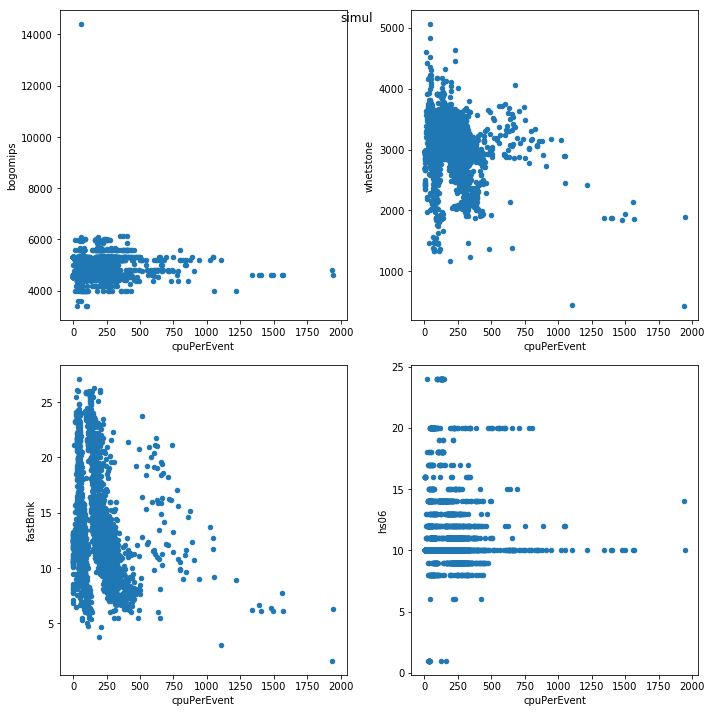

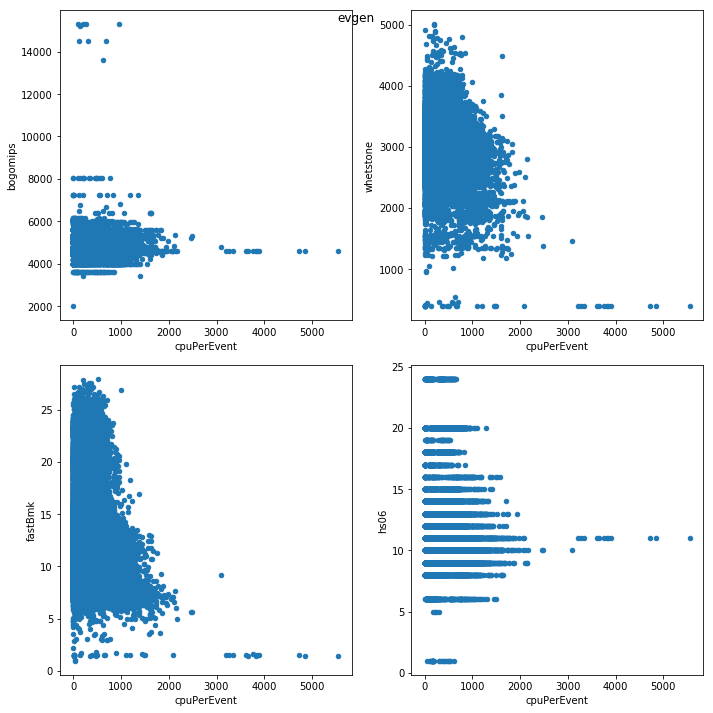

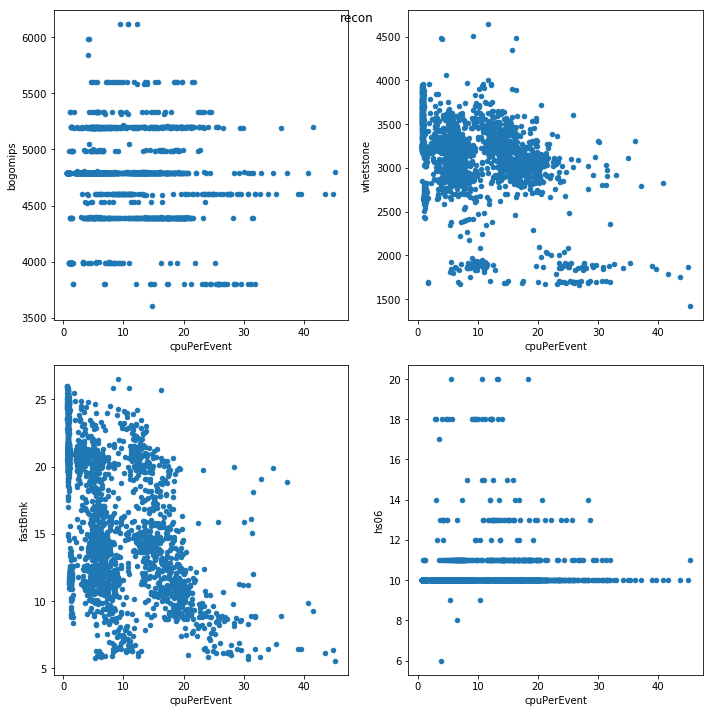

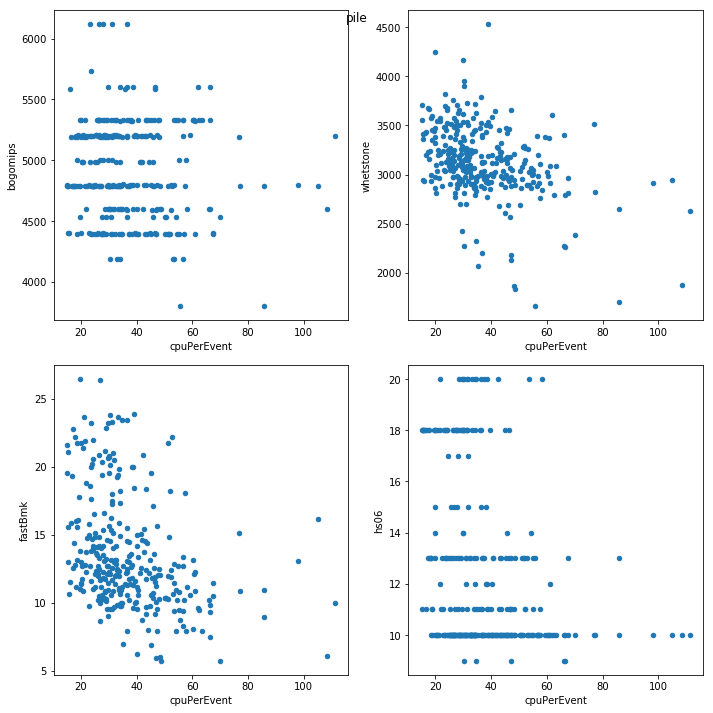

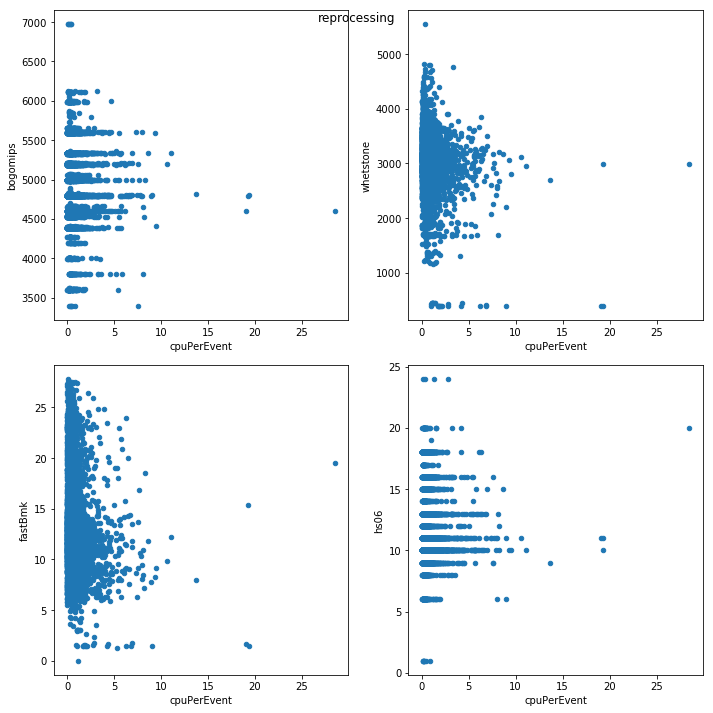

In [13]:
feat = ['bogomips', 'fastBmk', 'whetstone', 'hs06']
for pt in ProcessingType.keys():
    fig, axes = plt.subplots(nrows=2, ncols=2)
    fig.set_size_inches(10,10)
    plt.suptitle(pt)
    data = ProcessingType[pt]
    for nf, f in enumerate(feat):
        i = nf%2
        j = int(nf/2)
        data.plot(ax=axes[i,j], x="cpuPerEvent", y=f, kind='scatter') 
#         axes[i,j].hist2d(x=data["cpuPerEvent"], y=data[f], bins=30)#, norm=LogNorm())
#         axes[i,j].colorbar()
    fig.tight_layout()

### split on training and testing samples

===========  merge =============
(4590, 5) (4590, 1) (1148, 5) (1148, 1)
***  bogomips  ***
cross validation score:  0.298083624446
	evs: -0.0001 	mae:     0.2812 	mse:     0.4751 	r2:   -0.0001
***  fastBmk  ***
cross validation score:  0.297003990018
	evs: 0.0130 	mae:     0.2803 	mse:     0.4689 	r2:    0.0130
***  whetstone  ***
cross validation score:  0.299985888406
	evs: 0.0218 	mae:     0.2813 	mse:     0.4647 	r2:    0.0218
***  hs06  ***
cross validation score:  0.298979861678
	evs: 0.0008 	mae:     0.2824 	mse:     0.4747 	r2:    0.0008
Describe predictions
             actual     bogomips      fastBmk         hs06    whetstone
count  1148.000000  1148.000000  1148.000000  1148.000000  1148.000000
mean      0.336221     0.337059     0.339525     0.338268     0.336401
std       0.689528     0.003152     0.066576     0.018675     0.063325
min       0.004089     0.322157     0.120456     0.242234     0.029446
25%       0.061637     0.335252     0.306993     0.338159     0.30524

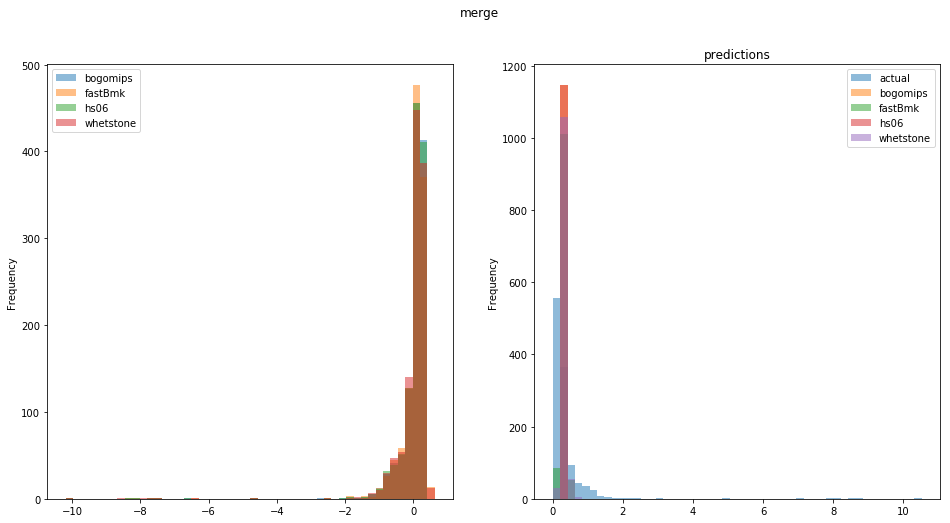

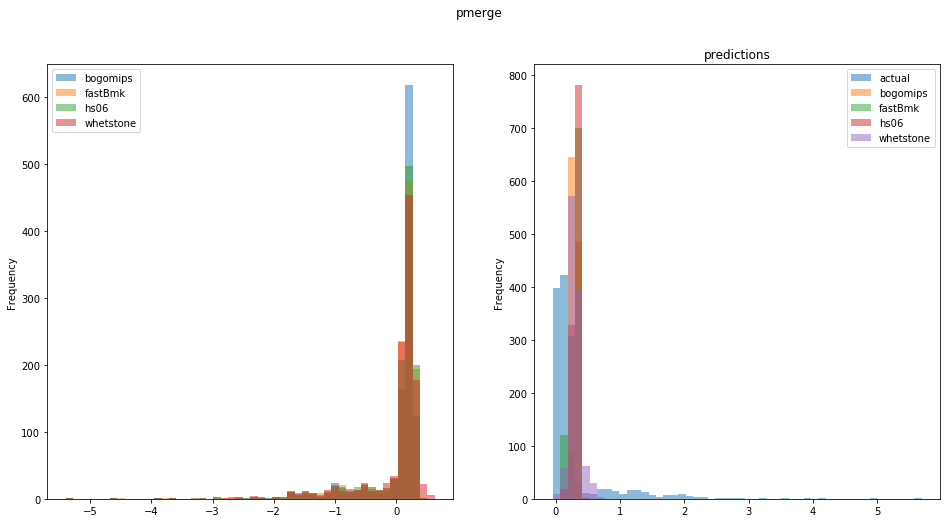

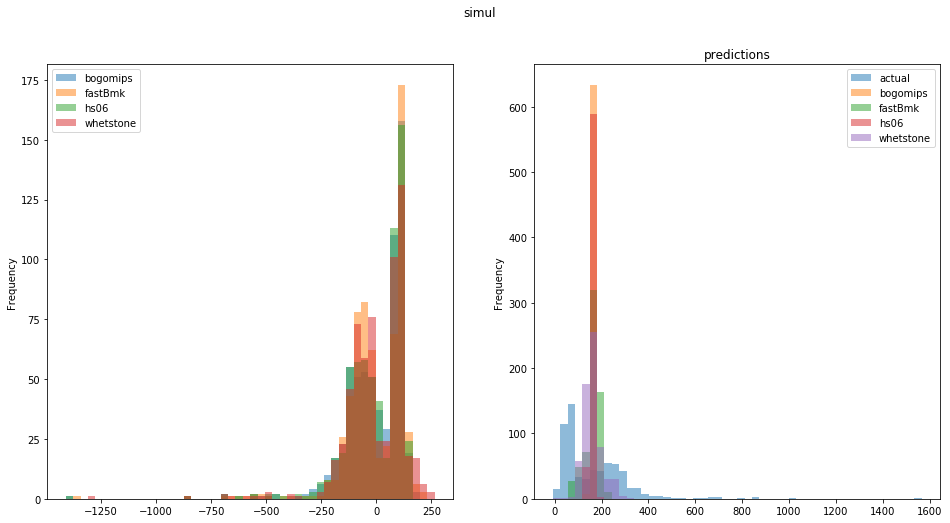

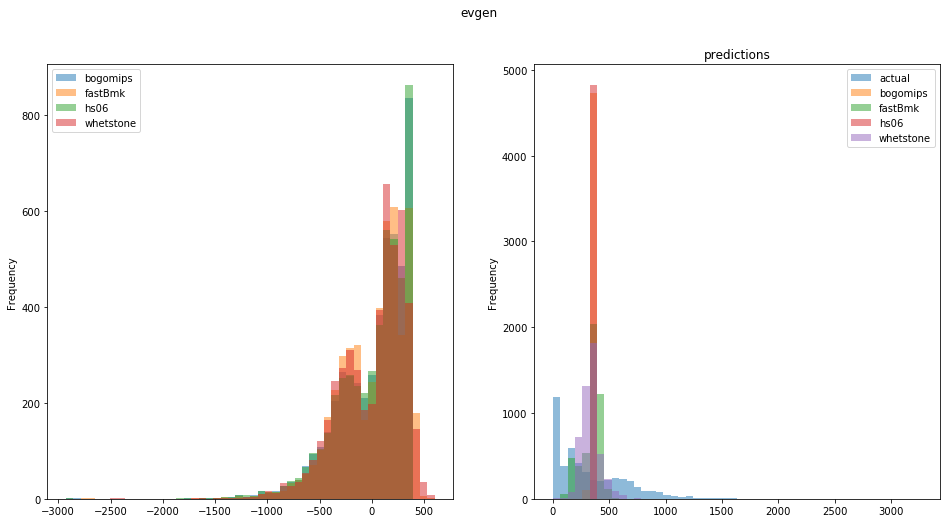

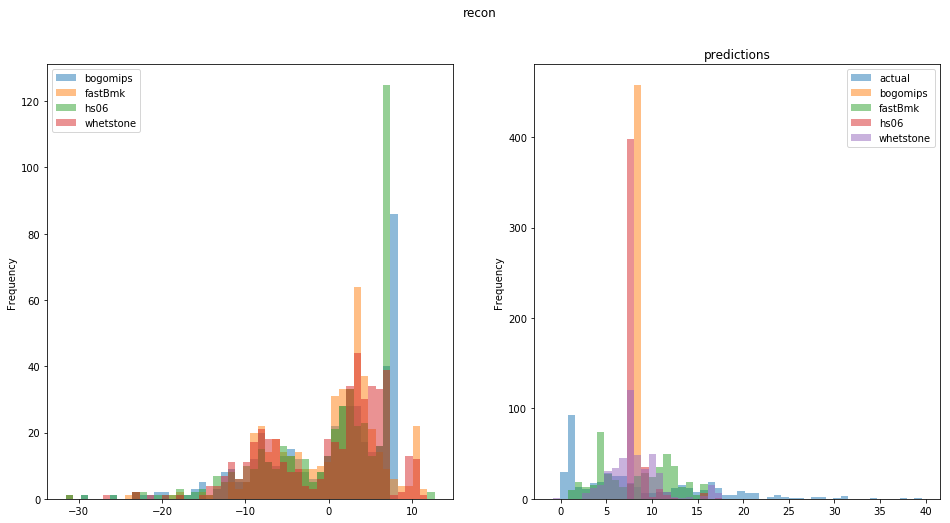

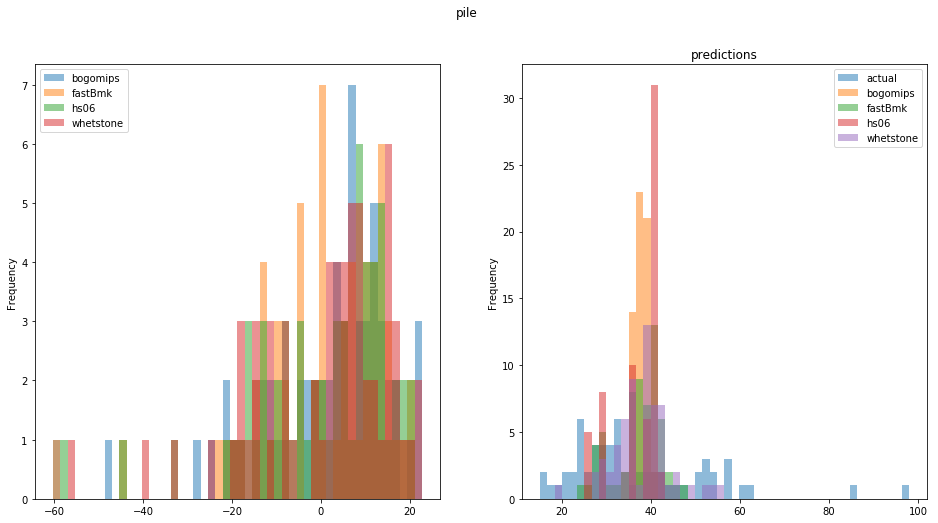

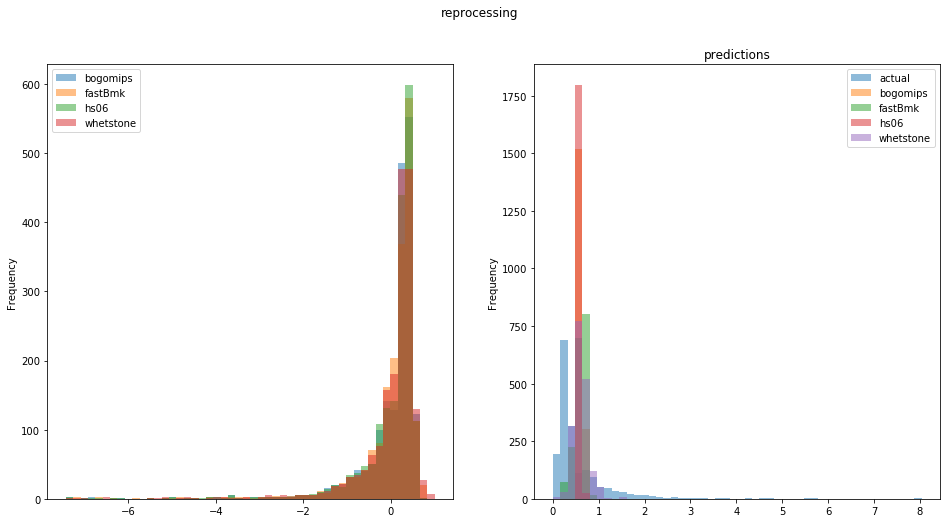

In [7]:
R_mse = {}
R_r2  = {}

#####  LRs ####
lr = LinearRegression()

for pt in ProcessingType:
    print("=========== ",pt,"=============")
    data = ProcessingType[pt]
    tmse=[]
    tr2=[]
    #target
    y = data['cpuPerEvent'].copy()
    y = y.values.reshape(-1, 1)
    #print(data['cpuPerEvent'].describe())
    
    X=data.copy()
    del X['cpuPerEvent']
    del X['processingtype']
    #print(X.columns)

    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20, random_state=41)
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    
    predictions={'actual':y_test.flatten()}
    errors = {}
    
    for f in feat:
        print( "*** ",f," ***")
        lr = LinearRegression()
        # to do cross validation 
        scores = cross_val_score(lr, X[f].values.reshape(-1,1), y, cv=10, scoring='neg_mean_absolute_error')
        #  [ 'adjusted_rand_score', 'average_precision', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 
        #   'neg_log_loss', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_median_absolute_error',  
        #   'precision_macro', 'precision_micro', 'precision_samples', 'r2', 
        #   'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'roc_auc']
        print("cross validation score: ", -scores.mean())
        
        lm = lr.fit(X_train[f].values.reshape(-1,1), y_train)
        #print ("Linear model:",lm.coef_ , lm.intercept_)
        #hold-out testing
        y_test_predict = lm.predict(X_test[f].values.reshape(-1,1))
        
        errors[f] = (y_test_predict-y_test).flatten().tolist()
        predictions[f] = y_test_predict.flatten().tolist()
        
        evs = explained_variance_score(y_test, y_test_predict)
        mae = mean_absolute_error(y_test, y_test_predict)
        mse = mean_squared_error(y_test, y_test_predict)
        r2 = r2_score(y_test, y_test_predict) 
        print("\tevs: %2.4f" % evs, "\tmae: {:>10.4f}".format(mae), "\tmse: {:>10.4f}".format(mse), "\tr2:{:>10.4f}".format(r2)) 
        tmse.append(mae)
        tr2.append(r2)
        #print("---------------------------------------")
    
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    plt.suptitle(pt)
    plt.title("errors")
    pl = pd.DataFrame(errors)
    #print("Describe residuals\n", pl.describe())
    pl.plot(ax=axes[0], kind='hist', figsize=(16, 8), bins=50, alpha=0.5) 
    
    pl = pd.DataFrame(predictions)
    plt.title("predictions")
    print("Describe predictions\n", pl.describe())
    pl.plot(ax=axes[1], kind='hist', figsize=(16, 8), bins=50, alpha=0.5) 
        
    ###  based on CPU
    cdata = data.copy()
    del cdata['processingtype']
    del cdata['bogomips']
    del cdata['fastBmk']
    del cdata['whetstone']
    del cdata['hs06']

    cdata_train, cdata_test =  train_test_split( cdata, test_size=0.20, random_state=41)
    print(cdata_train.shape, cdata_test.shape)

    predictions_on_CPU = cdata_train.groupby('cpuname').mean()
    #print(predictions_on_CPU)

    res=[]
    pre=[]
    not_used=0
    for index, row in cdata_test.iterrows():
        cn  = row['cpuname']
        cpe = row['cpuPerEvent']
        if cn in predictions_on_CPU.index:
            res.append(cpe)
            pre.append(predictions_on_CPU.loc[cn,'cpuPerEvent'])
        else:
            not_used += 1 

    #print(not_used,' test results had CPU not seen in training data.')
        
    #for i in range(len(res)):
    #    print(res[i], pre[i])
    comp=pd.DataFrame({'res':res,'pre':pre})
    #comp

    evs = explained_variance_score(comp.res, comp.pre)
    mae = mean_absolute_error(comp.res, comp.pre)
    mse = mean_squared_error(comp.res, comp.pre)
    r2 = r2_score(comp.res, comp.pre) 
    #print( "%2.4f" % evs, "{:>10.4f}".format(mae), "{:>10.4f}".format(mse), "{:>10.4f}".format(r2)) 
    tmse.append(mae)
    tr2.append(r2)
    R_mse[pt]=tmse
    R_r2[pt]=tr2
    print("---------------------------------------")
        
#print(R_r2)

### plot results

In [8]:
Results=pd.DataFrame(R_r2,index=['bogomips', 'fastBmk', 'whetstone', 'hs06','cpu name'])
Results

,evgen,merge,pile,pmerge,recon,reprocessing,simul
bogomips,0.001422,-0.000056,-0.004478,0.001315,0.000271,-0.003278,0.001443
fastBmk,0.074075,0.012996,0.100308,0.013316,0.285364,0.025744,0.037645
whetstone,0.074828,0.021801,0.026925,0.014612,0.137754,0.037964,0.017615
hs06,0.000485,0.000791,0.049420,0.004246,0.011904,0.000358,0.003429
cpu name,0.079781,-0.012650,0.101096,0.032762,0.384221,0.007744,0.104059


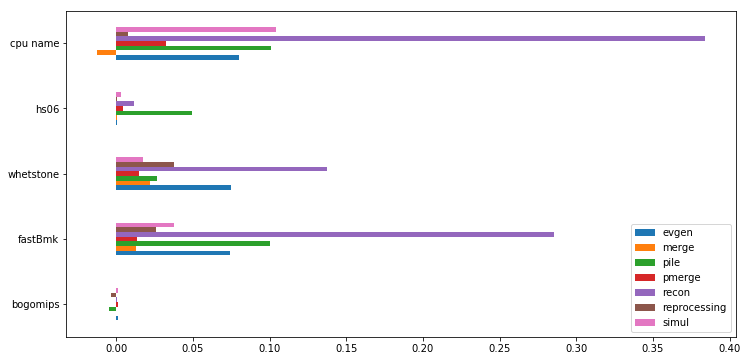

In [9]:
ax = Results.plot(kind='barh',figsize=(12, 6))
ax.get_figure().savefig("benchmarks_r2.png")

In [10]:
Results=pd.DataFrame(R_mse,index=['bogomips', 'fastBmk', 'whetstone', 'hs06','cpu name'])
Results

,evgen,merge,pile,pmerge,recon,reprocessing,simul
bogomips,264.836628,0.281237,11.926603,0.341068,6.120629,0.471723,104.145734
fastBmk,259.337282,0.280313,11.273908,0.338065,5.103776,0.462992,102.933346
whetstone,260.696788,0.281314,12.209156,0.339601,5.867779,0.460989,103.341382
hs06,264.983908,0.282356,11.996087,0.340614,6.054529,0.471376,103.794142
cpu name,254.274298,0.275343,11.053218,0.331494,4.428575,0.465849,87.712182


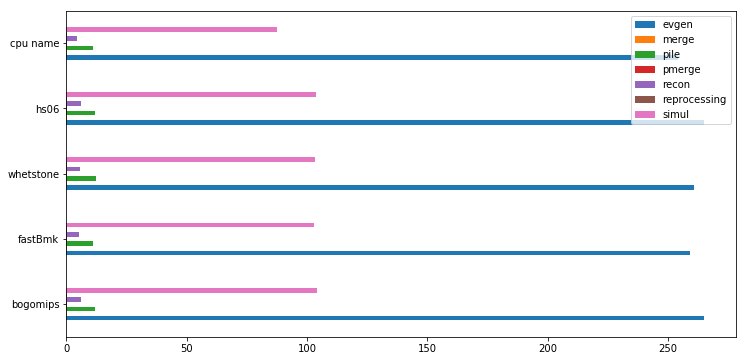

In [11]:
ax = Results.plot(kind='barh',figsize=(12, 6))
ax.get_figure().savefig("benchmarks_mse.png")